In [1]:
import os, time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import torch
import pickle
import matplotlib.pyplot as plt
import math

Before running, modify the last part of gene_thicket.py, to save the model and be able to load it again.

In [2]:
import sys

sys.path.append("/home/lorena/Documents/Lorena_Thesis/Causal_CNN/")

from libs.network_analysis import evaluation

from libs.run_gene_thicket import run_gene_thicket
from libs.causal_cnn import LaRed
from libs.gene_thicket import preparedata
from libs.network_analysis import plot_graph, scores, plot_scores, plot_cartography, evaluation

In [3]:
sns.set_style("whitegrid")

In [4]:
temp_path = './beeline_data/curated/HSC/HSC-2000-8-70'

gem = pd.read_csv(temp_path + '/ExpressionData.csv', index_col = 0) #read gem
pseudotime = pd.read_csv(temp_path + '/PseudoTime.csv', index_col = 0) #is distributed in columns, we need to make it one
pseudotime_all = pd.DataFrame({'pseudotime': pseudotime.fillna(0).sum(axis=1)}) #make one pseudotime
gem = gem.T #transpose
gem['pseudotime'] = pseudotime_all.values #add pseudotime to gem
        
data = gem.sort_values(by='pseudotime').drop('pseudotime', axis=1) #sort gem according to pseudotime
refs = pd.read_csv(temp_path + '/refNetwork.csv') #ground truth

In [6]:
links, _, losses =  run_gene_thicket(data, cuda=False, levels=0, patience=20)


 Analysis started for target:  Cebpa
Epoch:  1 [0%] 	Loss: 1.121177
Early stopping

 Analysis started for target:  EgrNab
Epoch:  1 [0%] 	Loss: 1.080795
Early stopping

 Analysis started for target:  Eklf
Epoch:  1 [0%] 	Loss: 0.294003
Early stopping

 Analysis started for target:  Fli1
Epoch:  1 [0%] 	Loss: 0.369911
Early stopping

 Analysis started for target:  Fog1
Epoch:  1 [0%] 	Loss: 0.632519
Early stopping

 Analysis started for target:  Gata1
Epoch:  1 [0%] 	Loss: 0.644889
Early stopping

 Analysis started for target:  Gata2
Epoch:  1 [0%] 	Loss: 0.008802
Early stopping

 Analysis started for target:  Gfi1
Epoch:  1 [0%] 	Loss: 1.103563
Early stopping

 Analysis started for target:  Pu1
Epoch:  1 [0%] 	Loss: 1.796381
Early stopping

 Analysis started for target:  Scl
Epoch:  1 [0%] 	Loss: 0.654000
Early stopping

 Analysis started for target:  cJun
Epoch:  1 [0%] 	Loss: 1.245566
Epoch: 500 [50%] 	Loss: 0.724391
Epoch: 1000 [100%] 	Loss: 0.722980


In [7]:
torch.cuda.empty_cache()

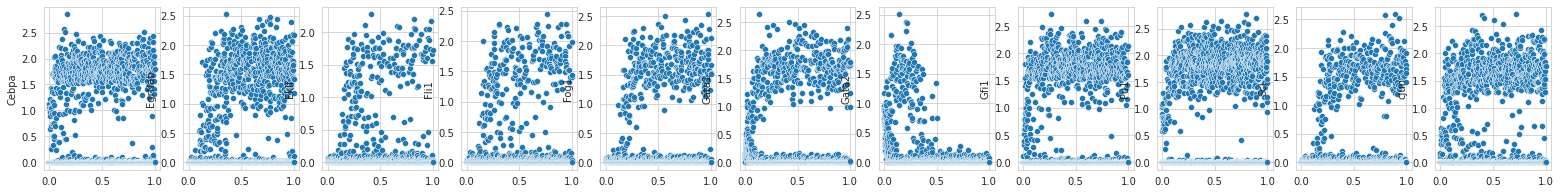

In [8]:
#time
time = pseudotime_all.sort_values(by='pseudotime').values.flatten()

fig, axs = plt.subplots(ncols=11, figsize=(27,3))

for i,col in enumerate(data.columns):
    sns.scatterplot(x=time, y=data[col], ax=axs[i])

In [9]:
#general parameters
gem = data.copy()
epochs = 1000
kernel_size = 4
layers = 0
lr = 0.01
optimizername = 'Adam'
seed = 1111
dilation_c = 4
input_channels = gem.shape[1]-1

In [10]:
model = LaRed(input_channels, layers, kernel_size=kernel_size, cuda=False, dilation_c=dilation_c)

In [11]:
all_genes = list(data.columns)

In [12]:
sel_genes = ['Cebpa', 'Gfi1', 'Gata1', 'Gata2']

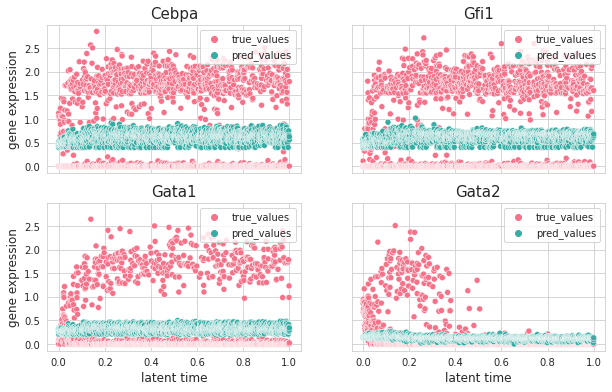

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 6))

#plt.figure(ncols=2, figsize=(20,10))

for i, el in enumerate(sel_genes):
    #parameters
    target_name = el
    tfs_name = all_genes.copy()
    tfs_name.remove(target_name)
    
    #train_data
    X_train, _ = preparedata(target_name, tfs_name, gem)
    input_channels = X_train.size()[1]
    
    #load model
    model.load_state_dict(torch.load('./saved_models/' + target_name + '.pt'))
    
    #predicted values
    model.eval()
    pred_values = model(X_train)
    pred_values = pred_values.cpu()
    pred_values =pred_values.detach().numpy().flatten()
    
    #true values
    true_values = data[target_name].values
    
    #data frame to plot
    df = pd.DataFrame({'time':time, 'true_values':true_values, 'pred_values':pred_values})
    df_plot = pd.melt(df, id_vars=['time'], value_vars=['true_values', 'pred_values'])
    
    sns.scatterplot(data=df_plot, x="time", y="value", hue="variable", palette=sns.color_palette("husl", 2), ax = axs[math.floor(i/2),i%2])
    axs[math.floor(i/2),i%2].set_title(el, fontdict={'fontsize':15})
    if (math.floor(i/2) == 0) | (math.floor(i/2) == 1):
        axs[math.floor(i/2),i%2].set_ylabel('gene expression', fontsize=12)
    if (math.floor(i/2) == 1):
        axs[math.floor(i/2),i%2].set_xlabel('latent time', fontsize=12)
        
    axs[math.floor(i/2),i%2].legend(loc='upper right')
    
plt.savefig("./Plots/prediction_example_bad.png", dpi=150, transparent=True, bbox_inches='tight')

/home/lorena/anaconda3/envs/causal_cnn_env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


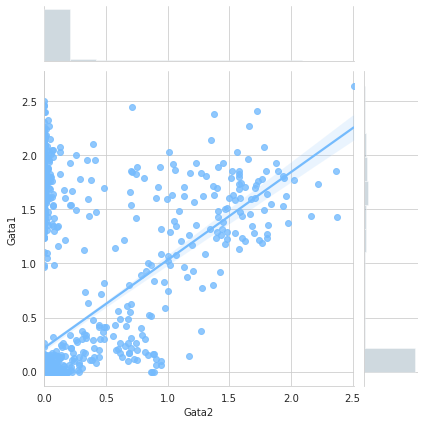

In [14]:
g = sns.JointGrid(x=data['Gata2'], y=data['Gata1'])
#g = sns.JointGrid(data=df, x='Height', y='Weight', xlim=(140, 190), ylim=(40, 100), height=5)
g = g.plot_joint(sns.regplot, color="xkcd:sky blue")
g = g.plot_marginals(sns.distplot, kde=False, bins=12, color="xkcd:bluey grey")
plt.savefig('./Plots/pearson_corr.png', dpi=150, transparent=True, bbox_inches='tight')
#g.ax_joint.text(145, 95, 'r = 0.45, p < .001', fontstyle='italic')